In [1]:
import torch
from augerino import datasets, models
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from augerino.models.e2_steerable import C8SteerableCNN, SmallE2
from smallnet import smallnet

/home/sp2058/miniconda3/envs/augerino/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
use_cuda = torch.cuda.is_available()

In [3]:
checkpt_path = "./orig-data/"
new_checkpt_path = "./our-data-120/"
ncopies = 12

In [4]:
# net = smallnet(in_channels=1,num_targets=10)
# augerino = models.UniformAug()
# low_model = models.AugAveragedModel(net, augerino,ncopies=ncopies)

net = smallnet(in_channels=1,num_targets=10)
augerino = models.UniformAug()
mid_model = models.AugAveragedModel(net, augerino,ncopies=ncopies)

net = smallnet(in_channels=1,num_targets=10)
augerino = models.UniformAug()
high_model = models.AugAveragedModel(net, augerino,ncopies=ncopies)

In [5]:
# low_model.load_state_dict(torch.load(checkpt_path + "model0.01.pt"))
mid_model.load_state_dict(torch.load(new_checkpt_path + "model0.1.pt"))
high_model.load_state_dict(torch.load(checkpt_path + "model0.1.pt"))

<All keys matched successfully>

In [6]:
net = smallnet(in_channels=1,num_targets=10)
augerino = models.UniformAug()
init_model = models.AugAveragedModel(net, augerino,ncopies=ncopies)
init_model.load_state_dict(torch.load(checkpt_path + "model0.1_init.pt"))

<All keys matched successfully>

In [7]:
# e2_model = SmallE2(channel_in=1, n_classes=10, rot_n=10)
# e2_model.load_state_dict(torch.load("./saved-outputs/e2_epoch200.pt", map_location='cpu'))

In [8]:
dataset = datasets.RotMNIST("~/datasets/", train=True)
trainloader = DataLoader(dataset, batch_size=128)


/home/sp2058/miniconda3/envs/augerino/lib/python3.11/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/sp2058/miniconda3/envs/augerino/lib/python3.11/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [9]:
img, lab = next(iter(trainloader))
init_aug = init_model.aug(img)
end_aug = high_model.aug(img)

## Let's Mess Around With Rotating Inputs

In [10]:
dataset = datasets.RotMNIST("~/datasets/", train=False)
testloader = DataLoader(dataset, batch_size=128)
testimg, testlab =next(iter(trainloader))

In [11]:
from jax import random
from augerino.inv.input import get_data
from augerino.configs.pgm_mnist import get_config

rng = random.PRNGKey(0)
(
    data_rng,
    proto_init_rng,
    gen_init_rng,
    proto_state_rng,
    gen_state_rng,
) = random.split(rng, 5)

config = get_config(f"{120}")

config.batch_size = 128
config.num_epochs = 1
train_ds, val_ds, _ = get_data(config, data_rng)

/home/sp2058/miniconda3/envs/augerino/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
I0000 00:00:1704374859.961244  684421 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [12]:
torch.where(testlab==4)

(tensor([  2,   9,  20,  26,  53,  58,  60,  61,  64,  89,  92, 115, 127]),)

In [13]:
ind = 64

In [14]:
n_ang = 50
angles = torch.linspace(-np.pi, np.pi, n_ang)

four = testimg[ind, ::].unsqueeze(0)
batch_four = torch.cat(n_ang * [four])


with torch.no_grad():
    # Build affine matrices for random translation of each image
    affineMatrices = torch.zeros(n_ang,2,3)
    affineMatrices[:,0,0] = angles.cos()
    affineMatrices[:,1,1] = angles.cos()
    affineMatrices[:,0,1] = angles.sin()
    affineMatrices[:,1,0] = -angles.sin()

    flowgrid = F.affine_grid(affineMatrices, size = batch_four.size())
    
    rot_four = F.grid_sample(batch_four, flowgrid)
    
    print(rot_four.shape)
    print(rot_four.min(), rot_four.max())
    

torch.Size([50, 1, 28, 28])
tensor(-2.) tensor(1013.8655)


/home/sp2058/miniconda3/envs/augerino/lib/python3.11/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/sp2058/miniconda3/envs/augerino/lib/python3.11/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [28]:
# low_model.eval();
high_model.eval();
mid_model.eval();
# e2_model.eval();


print(mid_model.aug.width)
print(high_model.aug.width)

theta_i = torch.nn.Softplus()(mid_model.aug.width[2])

print(theta_i)
sin_angle = torch.exp(theta_i)
angle = torch.asin(sin_angle)

print(angle)

Parameter containing:
tensor([-5.6148, -4.2004, 12.5546, -9.9631, -5.7665, -7.6668],
       requires_grad=True)
Parameter containing:
tensor([-8.5859, -6.1661, 14.1457, -6.6726, -8.5272, -7.6608],
       requires_grad=True)
tensor(12.5546, grad_fn=<SoftplusBackward0>)
tensor(nan, grad_fn=<AsinBackward0>)


In [16]:
# low_model.train();
# high_model.train();
# mid_model.train();
# e2_model.train();

tensor(-2.) tensor(1013.8655)
tensor(-1.) tensor(1.)


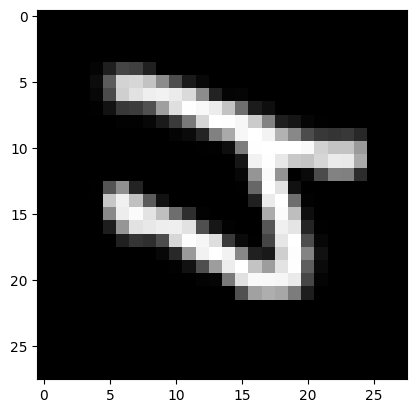

In [17]:
with torch.no_grad():
    # low_preds = low_model(rot_four)
    high_preds = high_model(rot_four)
    
    # normalise rot_four to [-1, 1]
    rot_four_new = (rot_four - rot_four.min())/(rot_four.max() - rot_four.min())
    rot_four_new = 2 * rot_four_new - 1
    print(rot_four.min(), rot_four.max())
    print(rot_four_new.min(), rot_four_new.max())
    plt.imshow(rot_four_new[0,0,:,:], cmap='grey')
    mid_preds = mid_model(rot_four_new)

In [18]:
# with torch.no_grad():
#     e2_preds = e2_model(rot_four)

In [19]:
sftmx = torch.nn.Softmax(-1)
# low_probs = sftmx(low_preds)
high_probs = sftmx(high_preds)
mid_probs = sftmx(mid_preds)

# print(high_probs)
# print(mid_probs)
# e2_probs = sftmx(e2_preds)

In [20]:
tick_pts = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
tick_labs = [r"-$\pi$", r'-$\pi$/2', '0', r'$\pi$/2', r'$\pi$']

#### distribution plot

In [21]:
softplus = torch.nn.Softplus()
test_pts = torch.linspace(-2, 2, 10)

In [22]:
def get_density(test_pts, width):
    dist = torch.distributions.Uniform(-width/2., width/2.)
    dens = dist.log_prob(test_pts).exp().detach()
    return dens

In [23]:
# init_dens = get_density(test_pts, softplus(torch.tensor(-1.)))
# high_dens = get_density(test_pts, high_logger[500:501]['width2'].values[0])
# mid_dens = get_density(test_pts, mid_logger[500:501]['width2'].values[0])
# low_dens = get_density(test_pts, low_logger[500:501]['width2'].values[0])

In [24]:


# init_dens = get_density(test_pts, width

init_test_pts = torch.linspace(-softplus(torch.tensor(-1.))/2, 
                               softplus(torch.tensor(-1.))/2, 10)

init_dens = get_density(init_test_pts, softplus(torch.tensor(-1.)))

width = min(softplus(high_model.aug.width[2]), 2*np.pi)
high_dens = get_density(test_pts, width)
width = min(softplus(mid_model.aug.width[2]), 2*np.pi)
mid_dens = get_density(test_pts, width)
# width = min(softplus(low_model.aug.width[2]), 2*np.pi)
# low_dens = get_density(test_pts, width)

## Plot it all

In [25]:
def plot_img(fig, img, i, j, label):
    ax = plt.Subplot(fig, inner[i,j])
    ax.imshow(img, cmap="Greys", interpolation='nearest')
    ax.set_title(label, fontsize=ax_fs+4, y=-0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

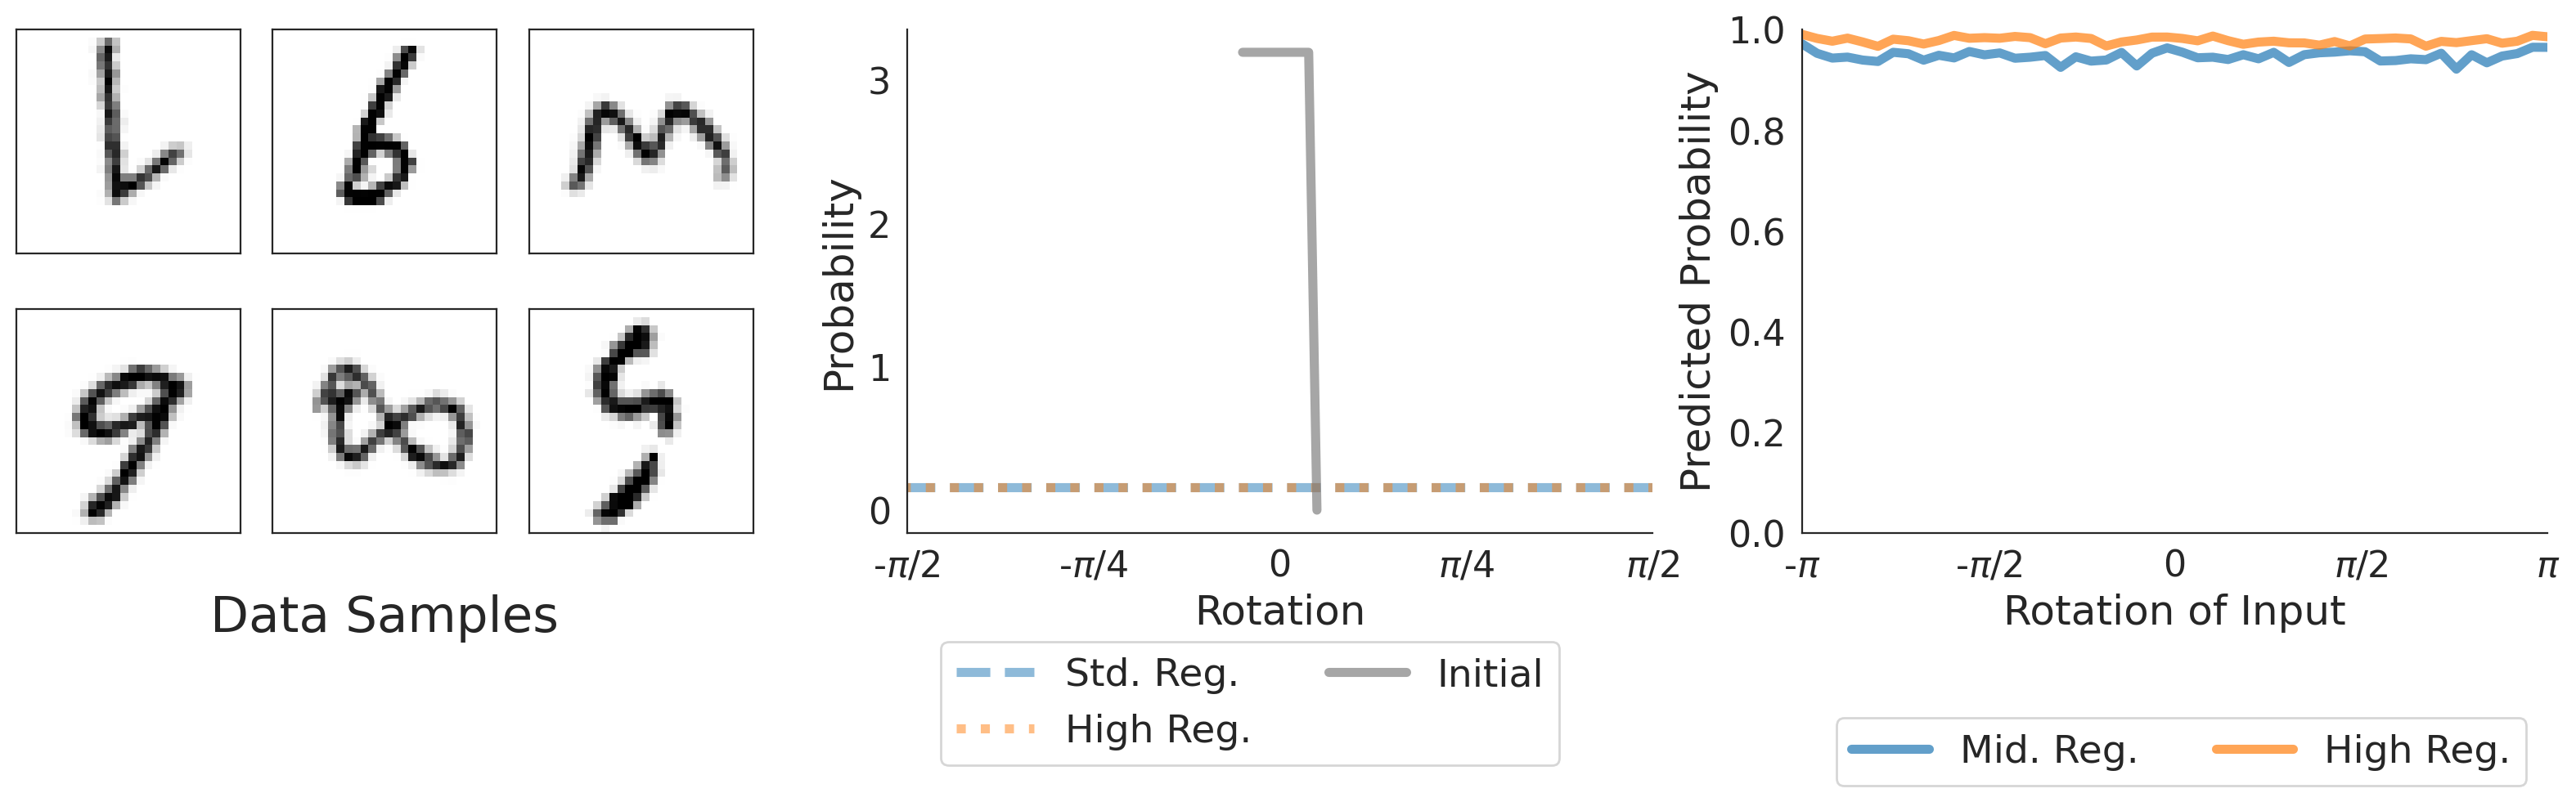

In [26]:
import matplotlib.gridspec as gridspec
sns.set_style("white")
fig = plt.figure(figsize=(20, 4), dpi=200)
outer = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.2)
alpha=0.5
ax_fs=18
lwd=4.
## plot mario and iggy

inner = gridspec.GridSpecFromSubplotSpec(2, 3,
                subplot_spec=outer[0], wspace=0.1, hspace=0.25)
ind=42
plot_img(fig, img[ind, 0, ::].cpu().detach(),
        0, 0, "")
plot_img(fig, img[ind+1, 0, ::].cpu().detach(),
        0, 1, "")
plot_img(fig, img[ind+2, 0, ::].cpu().detach(),
        0, 2, "")
plot_img(fig, img[ind+3, 0, ::].cpu().detach(),
        1, 0, "")
plot_img(fig, img[ind+4, 0, ::].cpu().detach(),
        1, 1, "Data Samples")
plot_img(fig, img[ind+5, 0, ::].cpu().detach(),
        1, 2, "")
ax = plt.Subplot(fig, inner[1, 1])
        
## Plot Learned Distribution
inner = gridspec.GridSpecFromSubplotSpec(1,1,
                    subplot_spec=outer[1], wspace=0.1, hspace=0.1)
ax = plt.Subplot(fig, inner[0])
# ax.plot(test_pts, low_dens.detach().cpu(), linewidth=lwd, label="No Reg.",
#         alpha=alpha, linestyle="-")
ax.plot(test_pts, mid_dens.detach().cpu(), linewidth=lwd, label="Std. Reg.",
        alpha=alpha, linestyle="--")
ax.plot(test_pts, high_dens.detach().cpu(), linewidth=lwd, label="High Reg.",
        alpha=alpha, linestyle=":")
ax.plot(init_test_pts, init_dens.detach(), linewidth=lwd, label="Initial", color='gray', alpha=0.7)
ax.legend(loc='lower left', fontsize=ax_fs-1, ncol=2,
           bbox_to_anchor=(0.02, -0.5))
ax.set_xlabel("Rotation", fontsize=ax_fs)
ax.set_ylabel("Probability", fontsize=ax_fs)
tick_pts = [-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2]
tick_labs = [r"-$\pi$/2", r'-$\pi$/4', '0', r'$\pi$/4', r'$\pi$/2']
ax.set_xticks(tick_pts)
ax.set_xticklabels(tick_labs)
ax.set_xlim(-np.pi/2, np.pi/2)
ax.tick_params("both", labelsize=ax_fs-2)
sns.despine(ax=ax)
fig.add_subplot(ax)


inner = gridspec.GridSpecFromSubplotSpec(1,1,
                    subplot_spec=outer[2], wspace=0.1, hspace=0.1)
ax = plt.Subplot(fig, inner[0])
alpha=0.7
num=4
lwd=4
# ax.plot(angles, low_probs[:, num].detach().cpu(), linewidth=lwd, label="Low Reg.",
#         alpha=alpha, linestyle="-")
ax.plot(angles, mid_probs[:, num].detach().cpu(), linewidth=lwd, label="Mid. Reg.",
        alpha=alpha, linestyle="-")
ax.plot(angles, high_probs[:, num].detach().cpu(), linewidth=lwd, label="High Reg.",
        alpha=alpha, linestyle="-")
# ax.plot(angles, e2_probs[:, num].detach().cpu(), linewidth=3, label="E2",
#         color='gray', alpha=0.6)
ax.set_ylim(0.0, 1.001)
ax.set_xlabel("Rotation of Input", fontsize=ax_fs)
ax.set_ylabel("Predicted Probability", fontsize=ax_fs)
tick_pts = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
tick_labs = [r"-$\pi$", r'-$\pi$/2', '0', r'$\pi$/2', r'$\pi$']
ax.tick_params("both", labelsize=ax_fs-2)
ax.set_xticks(tick_pts)
ax.set_xticklabels(tick_labs)

# ax.set_yticks([0.98, 0.99, 1.])
ax.set_xlim(-np.pi, np.pi)
ax.legend(loc="lower left", fontsize=ax_fs-1, ncol=2,
           bbox_to_anchor=(0.02, -0.54))
sns.despine(ax=ax)
fig.add_subplot(ax)
plt.savefig("./rotmnist_full.pdf", bbox_inches='tight')